In [1]:
import os
import shutil

def organize_emotions(source_directory, target_directory):
    # Dictionary mapping from the letter in filename to emotion
    emotion_map = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'anxiety',
        'F': 'happiness',
        'T': 'sadness',
        'N': 'neutral'
    }
    
    # Create directories for each emotion if they don't exist
    for emotion in emotion_map.values():
        os.makedirs(os.path.join(target_directory, emotion), exist_ok=True)
    
    # Iterate through each file in the source directory
    for filename in os.listdir(source_directory):
        if filename.endswith('.wav'):  # Check if it's a WAV file
            if len(filename) > 5:  # Ensure the filename has the correct length
                emotion_code = filename[5]  # Extract the emotion letter from filename
                emotion_folder = emotion_map.get(emotion_code)
                
                if emotion_folder:  # Check if the emotion code is valid
                    # Path to the source file and target file
                    src_path = os.path.join(source_directory, filename)
                    dst_path = os.path.join(target_directory, emotion_folder, filename)
                    
                    # Copy the file to the appropriate emotion directory (instead of move)
                    shutil.copy(src_path, dst_path)
                    print(f'Copied {filename} to {emotion_folder}/')
                else:
                    print(f'Unknown emotion code "{emotion_code}" in file {filename}')
            else:
                print(f'Filename {filename} is too short to extract emotion code.')

# Usage example
source_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'  # Update this path
target_dir = '/kaggle/working/EMODB'  # Update this path
organize_emotions(source_dir, target_dir)


Copied 15a04Fd.wav to happiness/
Copied 13b02Fb.wav to happiness/
Copied 09b01Wb.wav to anger/
Copied 15a01Wa.wav to anger/
Copied 14a05Wa.wav to anger/
Copied 03a05Aa.wav to anxiety/
Copied 11a04Wc.wav to anger/
Copied 09a05Tb.wav to sadness/
Copied 12a01Wc.wav to anger/
Copied 12a04Wc.wav to anger/
Copied 09a04La.wav to boredom/
Copied 08b02Nb.wav to neutral/
Copied 12b10Wa.wav to anger/
Copied 15a07Ld.wav to boredom/
Copied 10a07La.wav to boredom/
Copied 11a05Fb.wav to happiness/
Copied 03b01Nb.wav to neutral/
Copied 12b02Ea.wav to disgust/
Copied 08a01Ab.wav to anxiety/
Copied 10a01Ac.wav to anxiety/
Copied 12a02Wa.wav to anger/
Copied 14a02Fd.wav to happiness/
Copied 09a04Wa.wav to anger/
Copied 03b01Wa.wav to anger/
Copied 15a04Nc.wav to neutral/
Copied 09a05Lc.wav to boredom/
Copied 14a01Ea.wav to disgust/
Copied 09a02La.wav to boredom/
Copied 15b03Nb.wav to neutral/
Copied 14b02Wb.wav to anger/
Copied 12a07Ac.wav to anxiety/
Copied 11b01Wd.wav to anger/
Copied 08a07Wc.wav to an

In [2]:
import os
import csv

def create_csv_from_emotion_folders(target_directory, output_csv):
    # List of emotions that are present in the target directory
    emotions = ['disgust', 'anger', 'happiness', 'boredom', 'neutral', 'anxiety', 'sadness']
    
    # Open the CSV file for writing
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Emotion', 'Path'])
        
        # Iterate through each emotion folder
        for emotion in emotions:
            emotion_folder = os.path.join(target_directory, emotion)
            
            # Check if the folder exists and iterate through its files
            if os.path.exists(emotion_folder):
                for filename in os.listdir(emotion_folder):
                    if filename.endswith('.wav'):  # Ensure it's a .wav file
                        file_path = os.path.join(emotion_folder, filename)
                        writer.writerow([emotion, file_path])  # Write emotion and file path

# Usage example
target_dir = '/kaggle/working/EMODB'  # The directory where the emotion folders are located
output_csv = '/kaggle/working/Emodb.csv'  # Path to the output CSV file
create_csv_from_emotion_folders(target_dir, output_csv)


In [3]:
import pandas as pd
emodb = pd.read_csv("/kaggle/working/Emodb.csv")
emodb.head(10)

,Emotion,Path
0,disgust,/kaggle/working/EMODB/disgust/11b01Eb.wav
1,disgust,/kaggle/working/EMODB/disgust/09a07Eb.wav
2,disgust,/kaggle/working/EMODB/disgust/13a01Ea.wav
3,disgust,/kaggle/working/EMODB/disgust/15a07Eb.wav
4,disgust,/kaggle/working/EMODB/disgust/16a01Ec.wav
5,disgust,/kaggle/working/EMODB/disgust/16a05Ea.wav
6,disgust,/kaggle/working/EMODB/disgust/03b10Ec.wav
7,disgust,/kaggle/working/EMODB/disgust/15a01Ea.wav
8,disgust,/kaggle/working/EMODB/disgust/11a02Ec.wav
9,disgust,/kaggle/working/EMODB/disgust/15b01Ec.wav


In [4]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

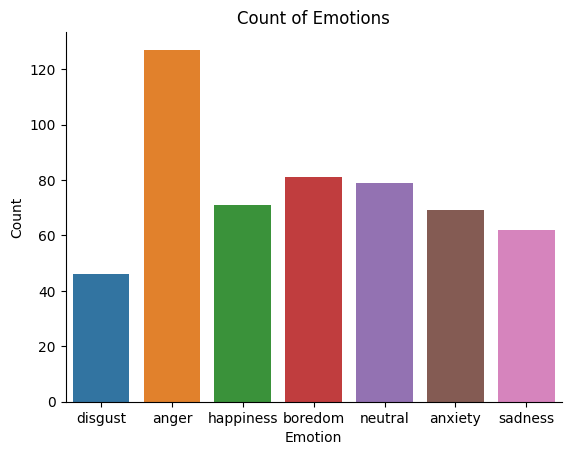

In [7]:
plt.title('Count of Emotions')
sns.countplot(x = emodb.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotion')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [8]:
def waveplot(data, sr, e):
  plt.figure(figsize = (10, 3))
  plt.title(f"{e} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (12, 3))
  plt.title(f"{e} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

In [9]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def waveplot(data, sr, emotion, ax):
    librosa.display.waveshow(data, sr=sr, ax=ax)
    ax.set_title(f'Waveform ({emotion})')

def spectrogram(data, sr, emotion, ax):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f'Spectrogram ({emotion})')
    return img


In [10]:
emodb['Emotion'].unique()

array(['disgust', 'anger', 'happiness', 'boredom', 'neutral', 'anxiety',
       'sadness'], dtype=object)

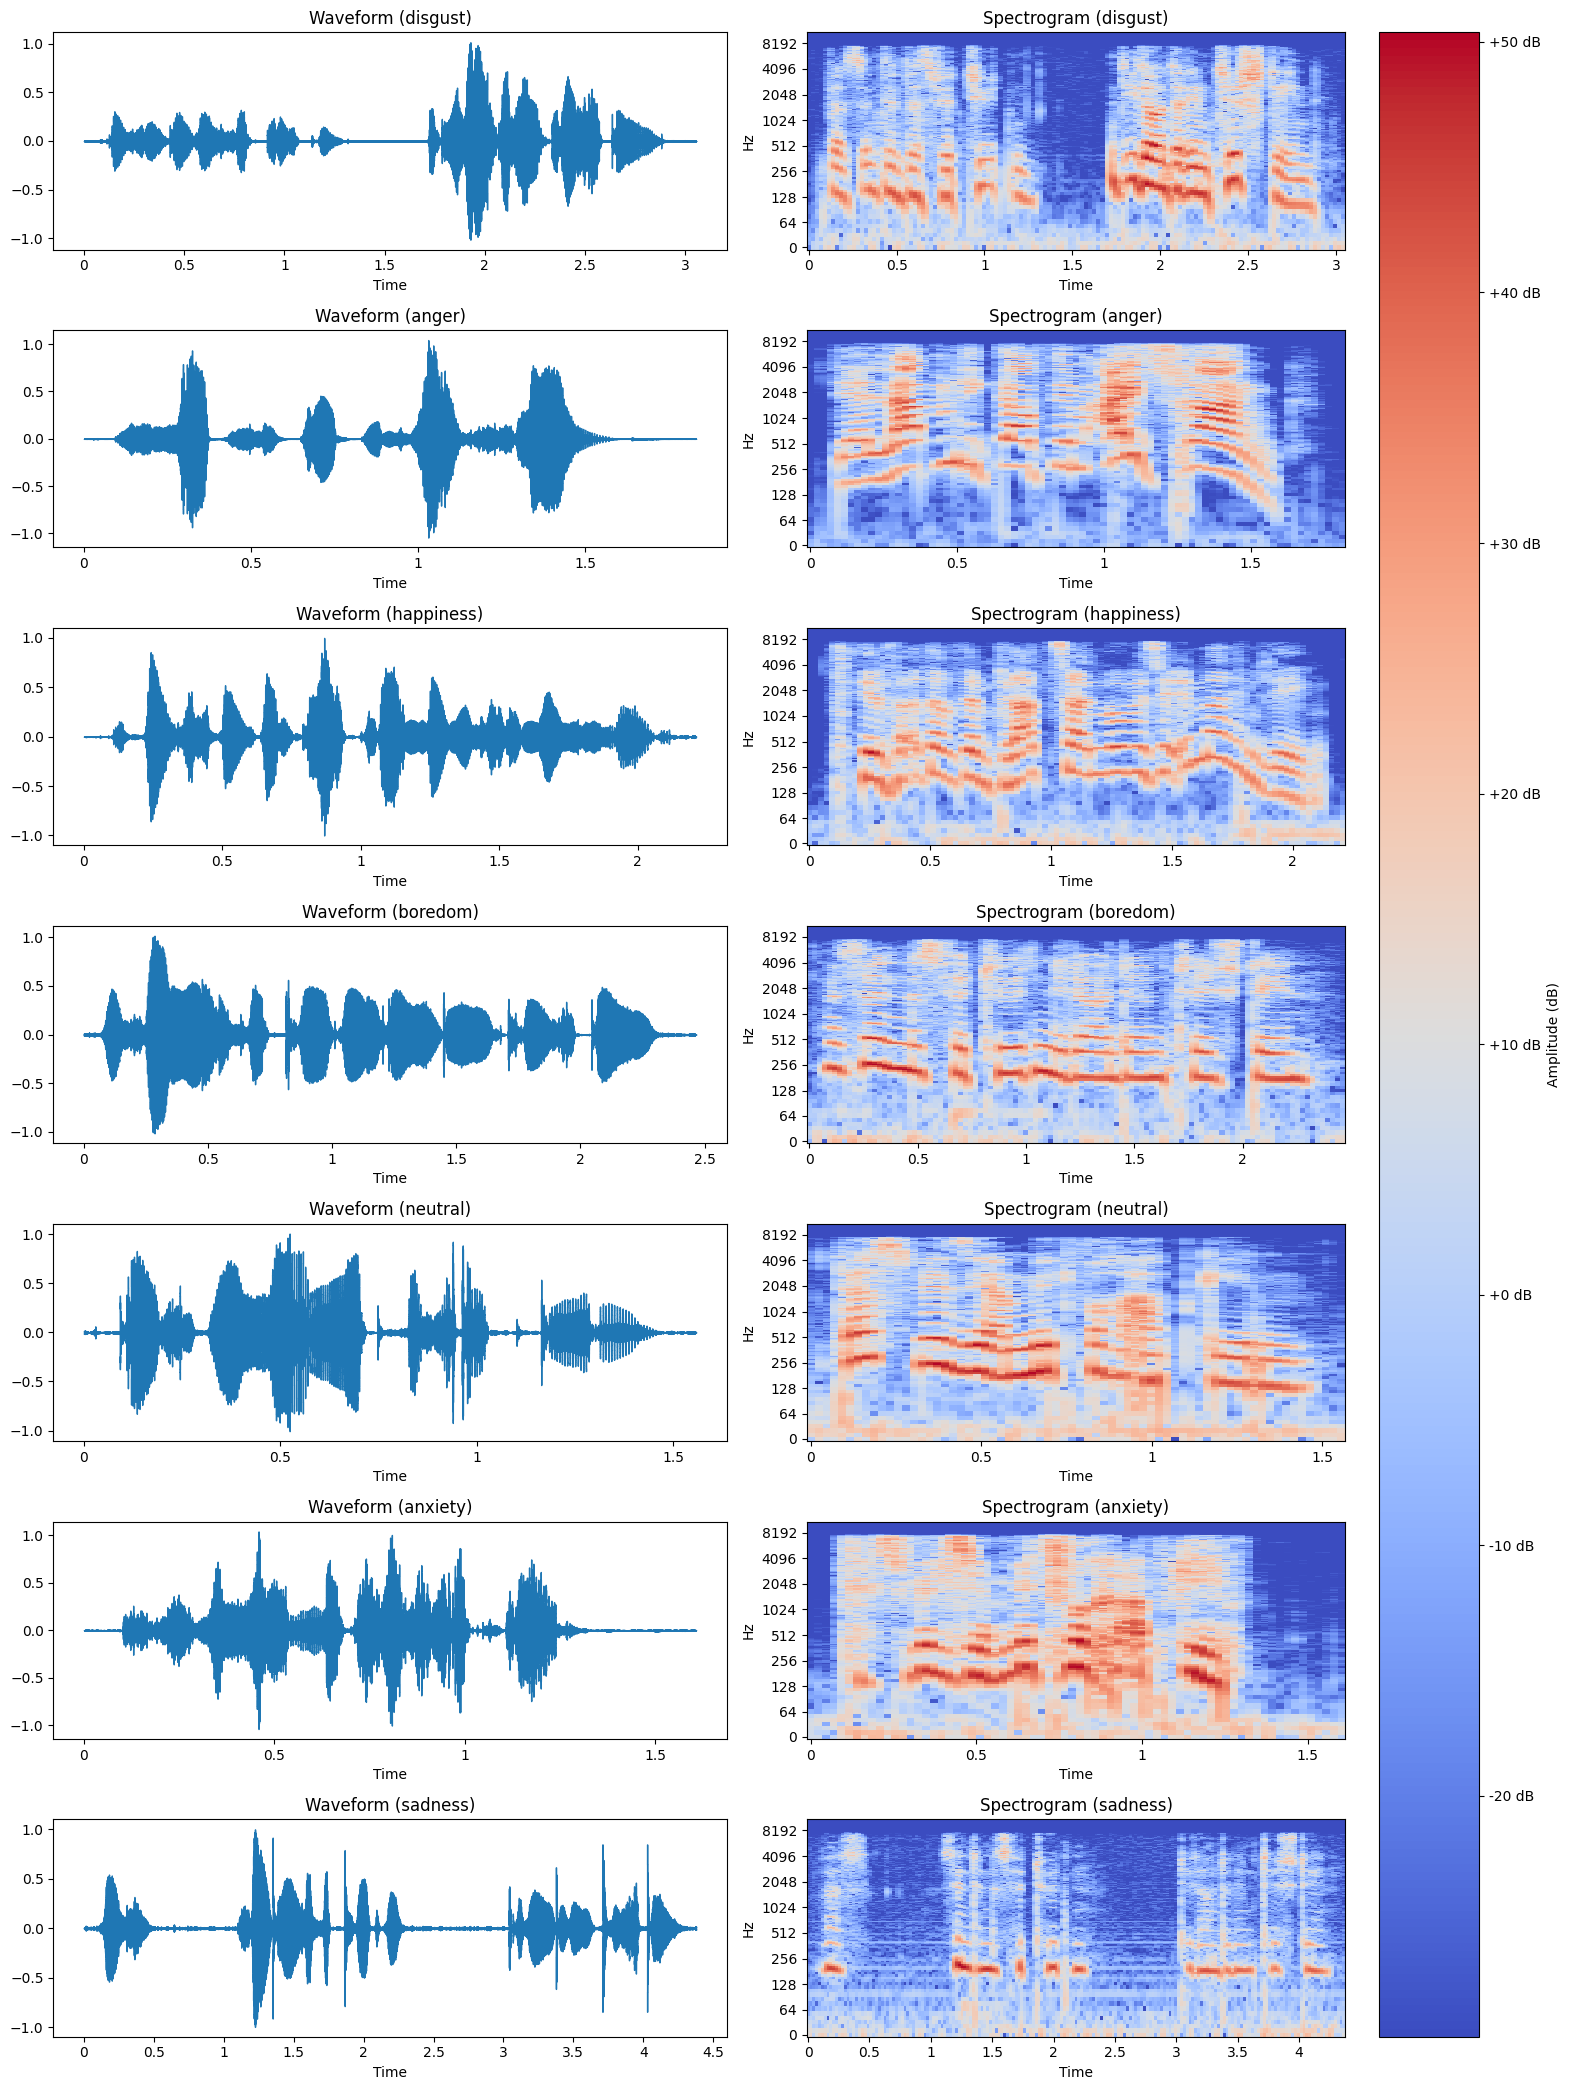

In [14]:
emotions = ['disgust', 'anger', 'happiness', 'boredom', 'neutral', 'anxiety','sadness']
fig, axs = plt.subplots(len(emotions), 2, figsize=(15, 3 * len(emotions)))

for i, emotion in enumerate(emotions):
    emotion_paths = emodb.Path[emodb.Emotion == emotion]
    if not emotion_paths.empty:
        path = np.array(emotion_paths)[0]  # Take the first path
        data, sr = librosa.load(path)
        waveplot(data, sr, emotion, axs[i, 0])
        img = spectrogram(data, sr, emotion, axs[i, 1])
    else:
        print(f"No paths found for emotion '{emotion}'")

plt.tight_layout()
cbar = fig.colorbar(img, ax=axs[:, 1], format="%+2.0f dB")
cbar.ax.set_ylabel('Amplitude (dB)')
plt.show()

In [16]:
def noise(data):
  noise_amp = 0.035 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
  shift_range = int(np.random.uniform(low = -5, high = 5) * 1000)
  return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

path = np.array(emodb.Path)[1]
data, sample_rate = librosa.load(path)

In [17]:
def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 20).T, axis = 0)
    result = np.hstack((result, mfcc))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    lowspeed_data = stretch(data, rate = 0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    highspeed_data = stretch(data, rate = 1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    pitch_data = pitch(data, sample_rate, n_steps = 0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6))

    return result

In [18]:
X, Y = [], []
for path, emotion in zip(emodb.Path, emodb.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [19]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(emodb.Path, emodb.Emotion):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()
#             print(path, " : ", emotion)

In [20]:
len(X), len(Y), emodb.Path.shape

(3210, 3210, (535,))

In [21]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index = False)
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,labels
0,-209.645798,105.633759,-34.677776,48.810452,-20.470081,30.021540,-32.569576,-0.479695,-21.699320,5.897713,5.025662,-3.834506,4.896657,-11.521724,12.884312,-14.818783,4.666123,3.318187,-1.251586,-3.868892,disgust
1,-134.219783,48.224792,0.567916,15.685580,0.320007,9.101189,-13.907351,-12.943203,-12.095146,0.237108,4.434214,-2.215363,-0.698548,-4.538863,3.700904,-6.606778,-2.240883,4.941269,-2.895795,-2.472936,disgust
2,-229.982544,104.118103,-34.755898,45.759525,-20.226486,28.918034,-33.842426,-2.754395,-21.513182,5.121784,6.113434,-4.503933,4.492157,-10.867786,12.970142,-14.072550,2.959172,4.480705,-0.626832,-4.938680,disgust
3,-218.728790,109.214287,-36.839710,48.328796,-21.556000,30.769773,-36.616222,-3.778738,-23.855021,2.736652,5.650013,-4.269265,5.420516,-11.647241,12.685493,-14.369445,2.380372,4.728746,-0.371768,-6.785860,disgust
4,-216.532791,98.852631,-33.350037,43.639389,-19.856106,25.792133,-40.607094,-0.772611,-24.427315,13.327247,-0.544810,0.532996,0.368386,-6.351758,8.570570,-15.157594,10.401446,0.504549,-2.595295,-6.091006,disgust


In [22]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [23]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2407, 20), (2407, 7), (803, 20), (803, 7))

In [25]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2407, 20), (2407, 7), (803, 20), (803, 7))

In [26]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2407, 20, 1), (2407, 7), (803, 20, 1), (803, 7))

In [29]:
model = Sequential([
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',input_shape = (x_train.shape[1], 1)),
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    
    Flatten(),
    Dense(units = 7, activation = 'softmax'),
    
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,399 (950.78 KB)

 Trainable params: 243,399 (950.78 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
mdcp = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True)
#early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, mdcp])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0054 - val_accuracy: 0.9489 - val_loss: 0.1687 - learning_rate: 1.0000e-07
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9489 - val_loss: 0.1687 - learning_rate: 1.0000e-07
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9489 - val_loss: 0.1687 - learning_rate: 1.0000e-07
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0060 - val_accuracy: 0.9489 - val_loss: 0.1687 - learning_rate: 1.0000e-07
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0041 - val_accuracy: 0.9489 - val_loss: 0.1687 - learning_rate: 1.0000e-07
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9489 - val_loss: 0.1687 - learning_rate: 1.0000e-07
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9980 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9469 - loss: 0.1794 
Testing Accuracy:  95.01867890357971 %


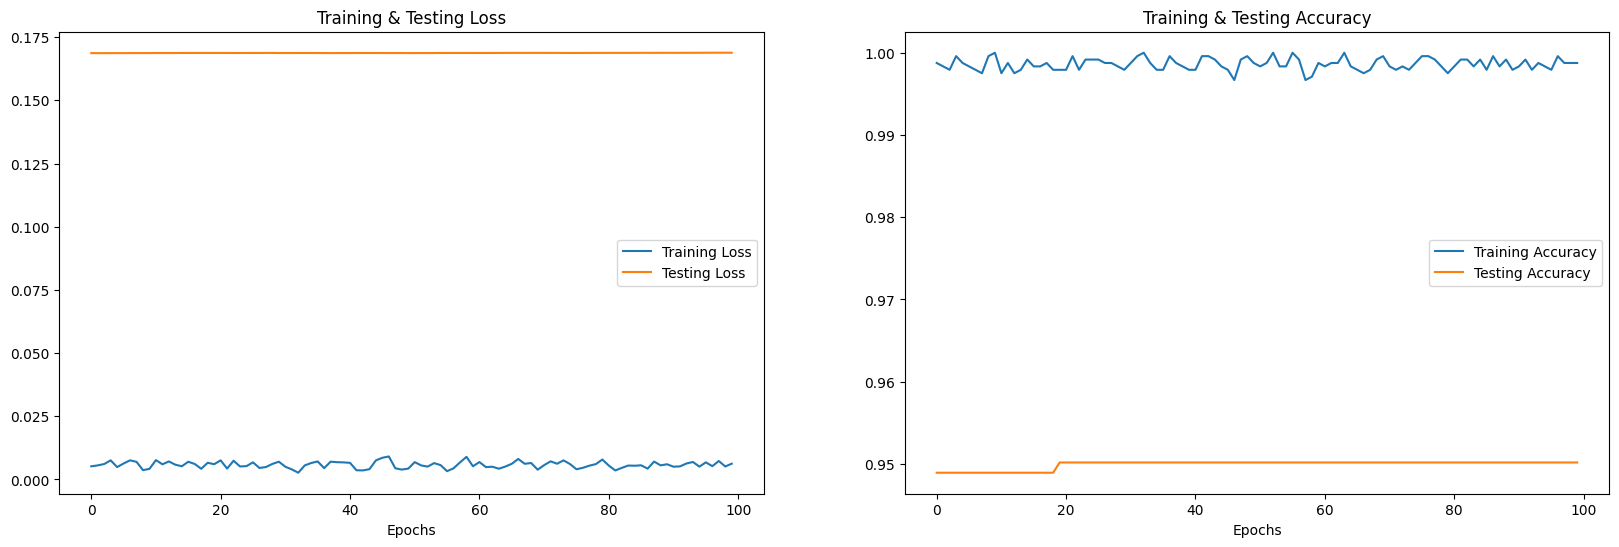

In [34]:
print("Testing Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [35]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [36]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,anger,anger
1,neutral,neutral
2,sadness,sadness
3,anxiety,anxiety
4,boredom,boredom
5,neutral,neutral
6,anger,anger
7,anxiety,anxiety
8,anger,anger
9,boredom,boredom


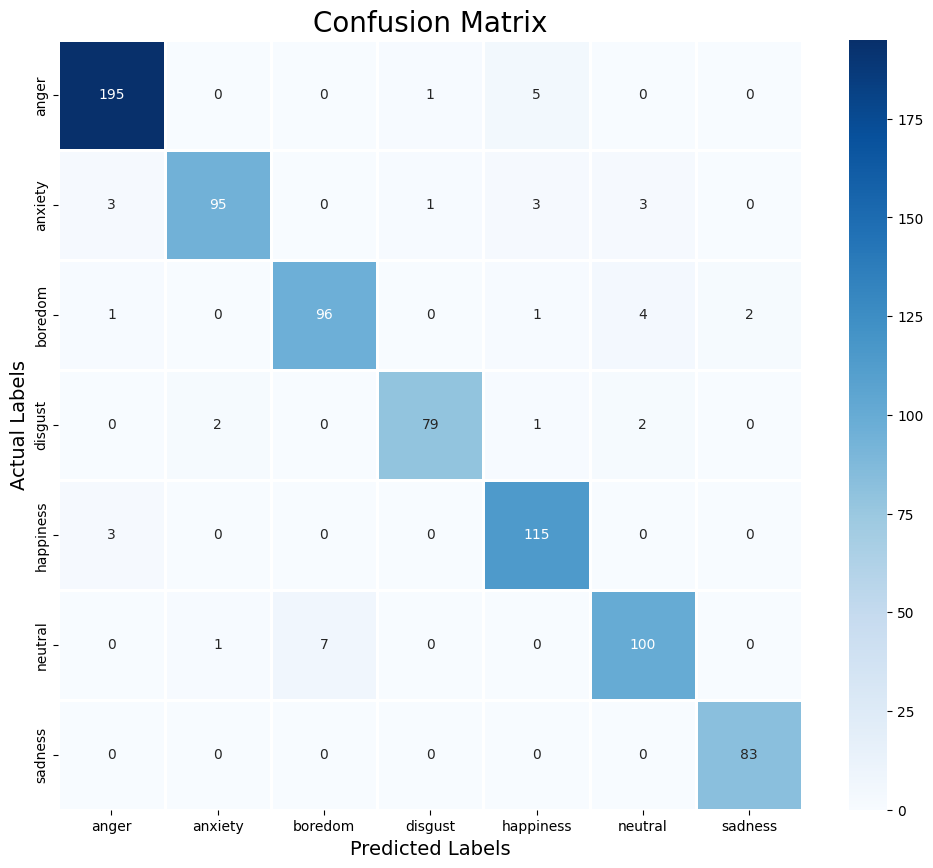

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [38]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

       anger       0.97      0.97      0.97       201
     anxiety       0.97      0.90      0.94       105
     boredom       0.93      0.92      0.93       104
     disgust       0.98      0.94      0.96        84
   happiness       0.92      0.97      0.95       118
     neutral       0.92      0.93      0.92       108
     sadness       0.98      1.00      0.99        83

    accuracy                           0.95       803
   macro avg       0.95      0.95      0.95       803
weighted avg       0.95      0.95      0.95       803

